In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import math

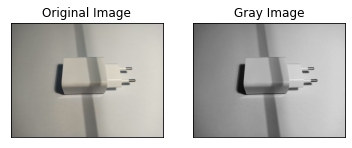

In [2]:
img = cv2.imread('../imgs/charger2.jpg')
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
f = plt.figure()
f.add_subplot(1,2, 1)

plt.imshow(rgb_img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])

f.add_subplot(1,2, 2)

plt.imshow(gray, cmap="gray")
plt.title('Gray Image'), plt.xticks([]), plt.yticks([])

plt.show(block=True)

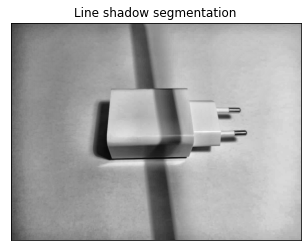

In [3]:
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
cl1 = clahe.apply(gray)

plt.imshow(cl1, cmap="gray")
plt.title('Line shadow segmentation')
plt.xticks([]), plt.yticks([])
plt.show()

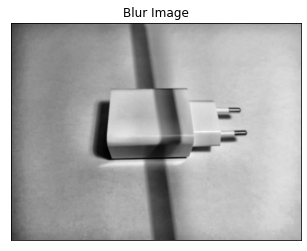

In [4]:
kernel_size = 7
blur = cv2.GaussianBlur(cl1,(kernel_size, kernel_size),0)
plt.imshow(blur, cmap="gray")
plt.title('Blur Image')
plt.xticks([]), plt.yticks([])
plt.show()

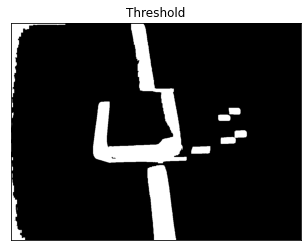

In [5]:
ret,thresh1 = cv2.threshold(cl1,100,255,cv2.THRESH_BINARY)
thresh1 = cv2.dilate(~thresh1,(1,7),iterations = 10)

plt.imshow(thresh1, cmap='gray', vmin=0)
plt.title('Threshold'), plt.xticks([]), plt.yticks([])
plt.show()

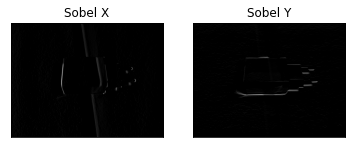

In [6]:
imgWithSobelX = cv2.Sobel(blur, cv2.CV_64F, 1, 0, ksize=5)
imgWithSobelY = cv2.Sobel(blur, cv2.CV_64F, 0, 1, ksize=5)

f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(imgWithSobelX, cmap='gray', vmin=0)
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
f.add_subplot(1,2, 2)
plt.imshow(imgWithSobelY, cmap = 'gray', vmin=0)
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])
plt.show(block=True)

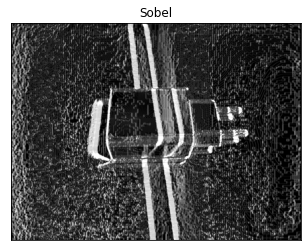

In [7]:
abs_grad_x = cv2.convertScaleAbs(imgWithSobelX)
abs_grad_y = cv2.convertScaleAbs(imgWithSobelY)
grad = cv2.addWeighted(abs_grad_x, 0.8, abs_grad_y,0.2, 0)
plt.imshow(grad, cmap='gray', vmin=0)
plt.title('Sobel'), plt.xticks([]), plt.yticks([])
plt.show()

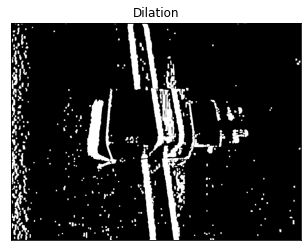

In [8]:
ret,thresh = cv2.threshold(grad,0,255,cv2.THRESH_BINARY + cv2.THRESH_OTSU)

kernel = np.ones((5,5),np.uint8)

erosion = cv2.erode(thresh,kernel,iterations = 1)
closing = cv2.morphologyEx(erosion, cv2.MORPH_CLOSE, (7,7))
dilation = cv2.dilate(closing,kernel,iterations = 1)

plt.imshow(dilation, cmap='gray', vmin=0)
plt.title('Dilation'), plt.xticks([]), plt.yticks([])
plt.show()

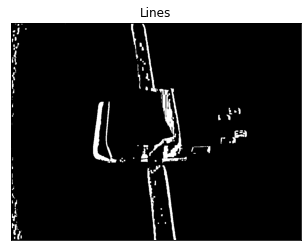

In [9]:
lines = cv2.bitwise_and(dilation,dilation, mask = thresh1)
plt.imshow(lines, cmap='gray', vmin=0)
plt.title('Lines'), plt.xticks([]), plt.yticks([])
plt.show()

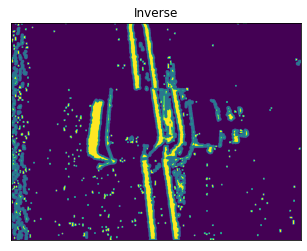

In [10]:
copy = dilation.copy()
contours, hierarchy = cv2.findContours(copy, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
img_copy = dilation.copy()
arr = []
for cnt in contours:
    epsilon = 0.01  *cv2.arcLength(cnt,True)
    approx = cv2.approxPolyDP(cnt,epsilon,True)
    if cv2.contourArea(approx) < 100: 
        continue
    arr.append(cnt)
    cv2.drawContours(img_copy,[cnt],0,(100,0,100),5)
    #cv2.drawContours(img_copy,[cnt],0,(0,0,100),5)

plt.imshow(img_copy)
plt.title('Inverse')
plt.xticks([]), plt.yticks([])
plt.show()

In [11]:
print(arr)

      [[744, 484]],

       [[744, 479]],

       [[740, 479]],

       [[739, 480]],

       [[737, 478]],

       [[737, 476]],

       [[738, 475]],

       [[738, 471]],

       [[737, 470]],

       [[737, 464]],

       [[732, 464]],

       [[731, 465]],

       [[731, 478]],

       [[730, 479]],

       [[729, 478]],

       [[729, 455]],

       [[728, 454]],

       [[728, 453]],

       [[727, 453]],

       [[726, 452]],

       [[726, 450]],

       [[725, 449]],

       [[725, 448]],

       [[728, 445]],

       [[728, 439]],

       [[729, 438]],

       [[729, 434]],

       [[728, 433]],

       [[728, 432]],

       [[727, 431]],

       [[727, 429]],

       [[726, 428]],

       [[726, 421]],

       [[725, 420]],

       [[725, 413]],

       [[724, 412]],

       [[724, 407]],

       [[723, 406]],

       [[723, 398]],

       [[722, 397]],

       [[722, 390]],

       [[721, 389]],

       [[721, 384]],

       [[720, 383]],

       [[720, 377]],

       [[71

In [12]:
def getMaxY(approx):
    max_y = -1
    for p in approx:
        p = p[0]
        if p[1] > min_y:
            max_y = p[1]
    return max_y
def getMinY(approx):
    min_y  = 100000000
    for p in approx:
        p = p[0]
        if p[1] < min_y:
            min_y = p[1]
    return min_y

In [13]:
processed = []
current = None
min_y  = 100000000
for approx in arr:
    for p in approx:
        p = p[0]
        if p[1] < min_y:
            min_y = p[1]
            current = approx

processed.append(current)
max_Y = getMaxY(current)
next = None
diff = 1000000
while current is not None:
    for approx in arr:
        d = getMinY(approx) - max_Y
        if d > 0 and d < diff:
            next = approx
            diff = d
    if next is not None:
        processed.append(next)
        current = next
        max_Y = getMaxY(current)
        diff = 1000000
        next = None
    else:
        break

In [14]:
for approx in processed:
    """rows,cols = img.shape[:2]
    [vx,vy,x,y] = cv2.fitLine(approx, cv2.DIST_L2,0,0.01,0.01)
    lefty = int((-x*vy/vx) + y)
    righty = int(((cols-x)*vy/vx)+y)
    cv2.line(img_copy,(cols-1,righty),(0,lefty),(255,255,0),2)"""
    cv2.drawContours(img_copy,[approx],0,(250,100,0),5)

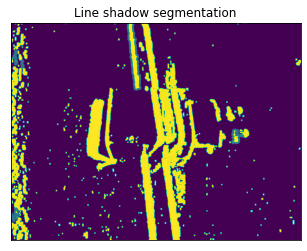

In [15]:
plt.imshow(img_copy)
plt.title('Line shadow segmentation')
plt.xticks([]), plt.yticks([])
plt.show()